# Scraping ECS 236th Meeting Abstract
by konkon

## Dataset download
In advance, please download abstracts of ECS 236th meeting from official page (https://www.electrochem.org/236/download-abstracts), and place unzipped file in same directory as this notebook.

## Imports

In [1]:
import bs4
import re
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import matplotlib.cm as cm

from tqdm import tqdm_notebook as tqdm
from ipywidgets import IntProgress

%matplotlib inline

## Scraping category and sessions from tos.html

In [2]:
# Load Table of Contents
soup = bs4.BeautifulSoup(open('./ECS MA2019-02.003/Abstracts/tos.html', encoding='utf-8'),'lxml')

# Function to remove html tags
px = re.compile(r"<[^>]*?>")

#Load Categories
p_len = len(soup('h2'))
categorys = []
for i in range(p_len):
    c = px.sub("", str(soup('h2')[i]))
    categorys.append(c)
print("categoly_num ="+str(p_len))
print(categorys)

categoly_num =14
['A—Batteries and Energy Storage', 'B—Carbon Nanostructures and Devices', 'C—Corrosion Science and Technology', 'D—Dielectric Science and Materials', 'E—Electrochemical/Electroless Deposition', 'F—Electrochemical Engineering', 'G—Electronic Materials and Processing', 'H—Electronic and Photnonic Devices and Systems', 'I—Fuel Cells, Electrolyzers, and Energy Conversion', 'J—Luminescence and Display Materials, Devices, and Processing', 'K—Organic and Bioelectrochemistry', 'L—Physical and Analytical Electrochemistry, Electrocatalysis, and Photoelectrochemistry', 'M—Sensors', 'Z—General Topics']


In [3]:
#Load Sessions
p_len = len(soup('h3'))
sessions = []
for i in range(p_len):
    c = px.sub("", str(soup('h3')[i]))
    sessions.append(c)
print("session_num ="+str(p_len))
print(sessions)

session_num =58
['A01-Battery and Energy Technology Joint General Session', 'A02-Symposium in Honor of Bob Huggins: Fast Ionic Conductors - Principles and Applications', 'A03-Fast Electrochemical Processes and Devices 3 (Electrochemical Capacitors and Batteries)', 'A04-Advanced Manufacturing Methods for Energy Storage Devices 2', 'A05-Lithium Ion Batteries', 'A06-Beyond Lithium Ion Batteries', 'A07-Solid State Batteries', 'B01-Carbon Nanostructures: From Fundamental Studies to Applications and Devices', 'C01-Corrosion General Session', 'C02-Oxide Films 4', 'C03-Localized Corrosion', 'C04-Computation Approaches in Corrosion Science and Engineering', 'D01-Semiconductors, Dielectrics, and Metals for Nanoelectronics 17', 'D02-Plasma Nanoscience and Technology 4', 'E01-Current Trends in Electrodeposition - An Invited Symposium', 'E02-Electrodeposition of Nanostructured Materials for Energy Application', 'E03-Ionic Liquids as Reactive Media for Electrodeposition Processes', 'F01-Industrial E

## Scraping all abstract text from html

In [4]:
#Load stopwords
with open('stopwords.txt', 'r', encoding='utf-8') as f:
    stops = f.readlines()
stopwords = []
for s in stops:
    s = s.replace("\n", "")
    stopwords.append(s)

In [5]:
dic_all = []

# make session number and name dictionary
dic_sessions = {}
for s in sessions:
    id_ = s.split('-',1)
    dic_sessions[id_[0]]=id_[1]

#Get all pathes of abstract .html file
path = os.listdir("./ECS MA2019-02.003/Abstracts/Html")

#Scraping html documents
for n,i in enumerate(tqdm(path)):
    soup = bs4.BeautifulSoup(open("./ECS MA2019-02.003/Abstracts/Html/"+i, encoding='utf-8'), "html5lib")
    
    #Get title, authors, affiliation
    title =px.sub("", soup.title.string)
    author = px.sub("", str(soup('p')[1]))
    author = author.split(', ')
    author = [a for a in author if len(a)>2]
    
    affiliation = soup.find_all('div',class_='header_inner')
    affiliation = affiliation[0].find_all('p')[2:]
    affiliations = []
    sup_list = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n']
    for m,a in enumerate(affiliation):
        a = px.sub("", str(a))
        affiliations.append(a.replace(sup_list[m], "", 1))
    affiliations = [a for a in affiliations if len(a)>2]

    
    #Get presentation number, session
    number = re.search('-[0-9]{4}', str(title))
    number = number.group().replace("-", "")
    session = re.match('.*[0-9]{2}', str(title))
    session = session.group()
    
    #Remove session name in title
    title = re.sub('\w[0-9]{2}-[0-9]{4}', "", title)
    title = title.replace(u"\xa0",u"")
    title = title.replace(session, '')
    title = title.replace('(Invited)', '')
    
    session = session.replace(number, '')
    session = session.replace('-', '')
    try:
        session_name = dic_sessions[session]
    except:
        session = session.split(u'\xa0',1)[0]
        session_name = dic_sessions[session]
        
    session_name = session_name.replace(u'&amp;', '&')
    
    #Get main text and reshape it
    content = px.sub("", str(soup.find(class_=re.compile('contaner_content'))))
    stoplist = [",", ".", ":", ";", "(", ")", "{", "}", "[", "]", "\'", "\""]
    for s in stoplist:
        content = content.replace(s, "")
    content = content.replace("\t", "")
    
    #Get word list for Word2Vec Learning
    c_list = content.split(" ")
    c_list = [c.lower() for c in c_list]
    for s in stopwords:
        c_list = [c for c in c_list if i != s]
    c_list = [c for c in c_list if c != ""]
    
    #Summarize it as dictionary
    dic ={'num':number,'title':title,'author':author,
          'affiliation':affiliations,'session':session, 'session_name':session_name,
          'contents':content, 'mod_contents': c_list, 'vector':n, 'url':i}
    
    dic_all.append(dic)

In [6]:
charactors = [i[0] for i in categorys]
cat_counts = np.zeros(len(charactors))
authors_counts = {}
words_counts = {}
affiliation_counts = {}

for c in charactors:
    authors_counts[c] = []
    words_counts[c] = []
    affiliation_counts[c] = []

for n,d in enumerate(dic_all):
    char = d['session'][0]
    cat_counts[charactors.index(char)] += 1
    authors_counts[char].append(len(d['author']))
    words_counts[char].append(len(d['contents'].split(' ')))
    affiliation_counts[char].append(len(d['affiliation']))

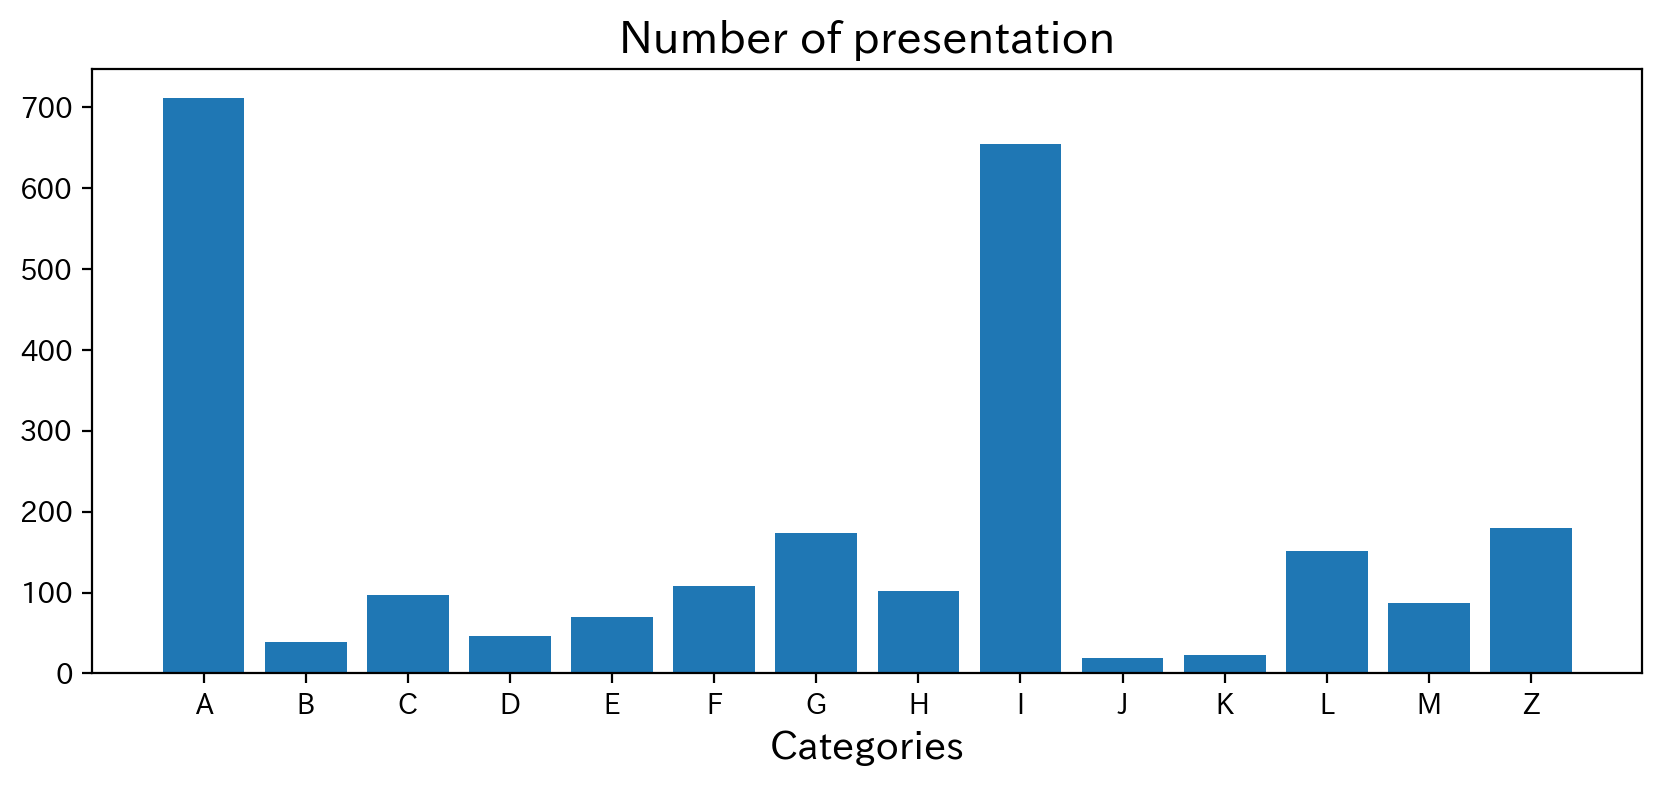

In [7]:
fig = plt.figure(figsize=(10,4),dpi=200)
plt.bar(charactors, cat_counts, label=categorys)
plt.xlabel('Categories',fontsize=14)
plt.title('Number of presentation',fontsize=16)
plt.show()

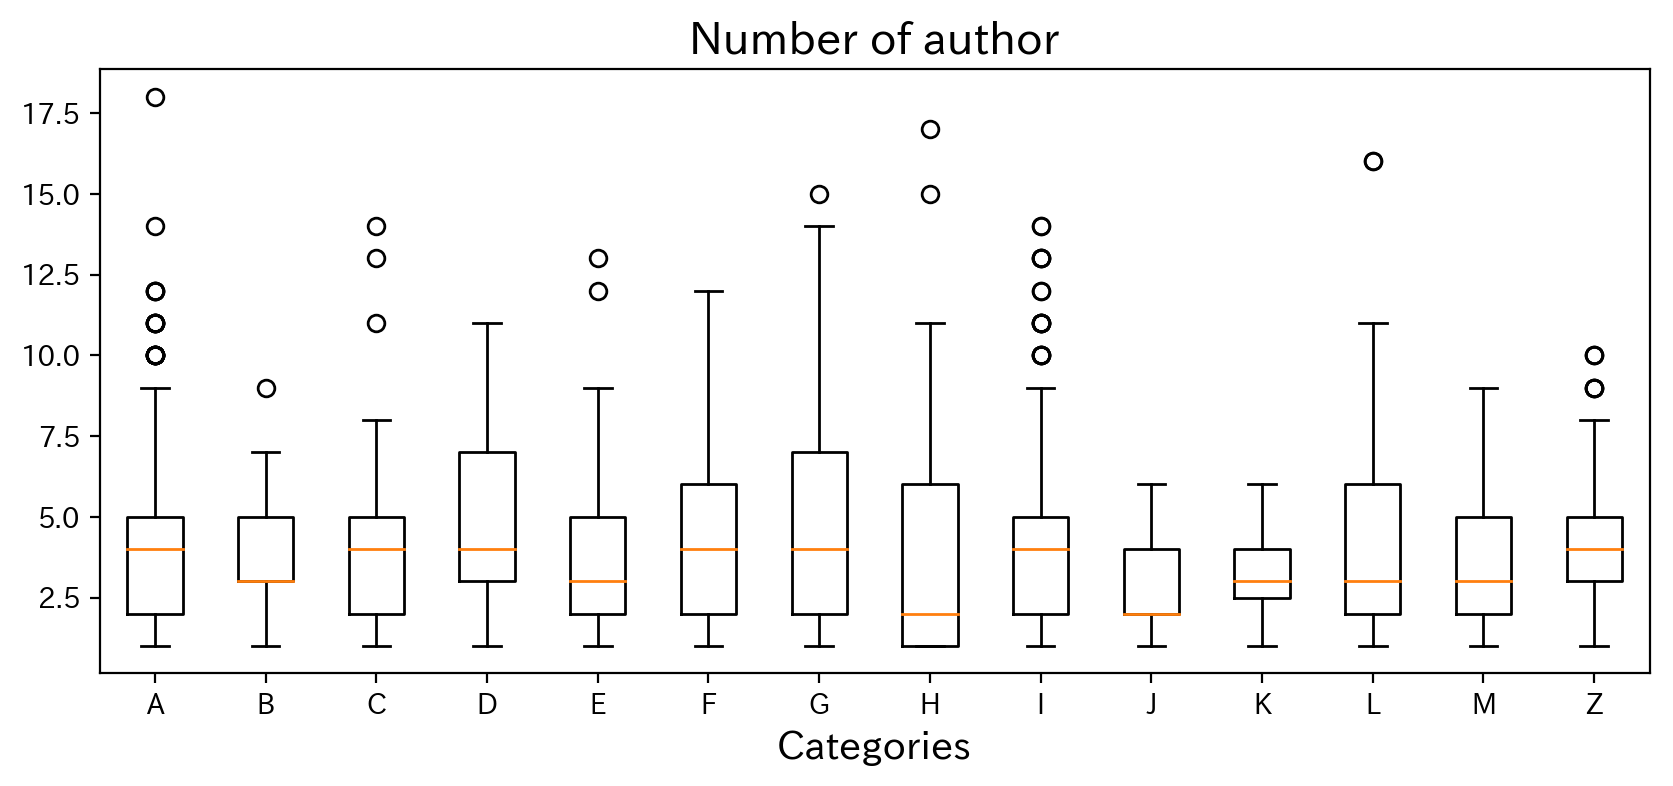

In [8]:
points = tuple(authors_counts[i] for i in charactors)
fig = plt.figure(figsize=(10,4),dpi=200)
plt.boxplot(points)
plt.gca().set_xticklabels(charactors)
plt.xlabel('Categories',fontsize=14)
plt.title('Number of author',fontsize=16)
plt.show()

In [9]:
import collections
affiliation_list = []
for a in dic_all:
    affiliation_list.extend(a['affiliation'])   
a_count = collections.Counter(affiliation_list)
a_sorted = sorted(a_count.items(), key=lambda x:x[1], reverse=True)

In [11]:
print('| Rank | Affiliation | Counts |')
print('| ---- | ---- | ---- |')
for n,i in enumerate(a_sorted[:20]):
    print('| '+str(n+1)+' | '+i[0]+' | '+str(i[1])+' |')

| Rank | Affiliation | Counts |
| ---- | ---- | ---- |
| 1 | Georgia Institute of Technology | 103 |
| 2 | Argonne National Laboratory | 73 |
| 3 | National Renewable Energy Laboratory | 56 |
| 4 | Lawrence Berkeley National Laboratory | 54 |
| 5 | Oak Ridge National Laboratory | 48 |
| 6 | University of South Carolina | 41 |
| 7 | Sandia National Laboratories | 33 |
| 8 | Massachusetts Institute of Technology | 31 |
| 9 | Los Alamos National Laboratory | 31 |
| 10 | Colorado School of Mines | 29 |
| 11 | Pacific Northwest National Laboratory | 28 |
| 12 | Purdue University | 27 |
| 13 | Tokyo Institute of Technology | 25 |
| 14 | Lawrence Livermore National Laboratory | 22 |
| 15 | Faraday Technology, Inc. | 21 |
| 16 | U.S. Naval Research Laboratory | 21 |
| 17 | Tohoku University | 21 |
| 18 | Auburn University | 20 |
| 19 | Kyushu University | 19 |
| 20 | University of Michigan | 18 |
